In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from itertools import product

In [3]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALID_EXTS = [".jpg", ".jpeg", ".png", ".bmp"]

# Path
base_dir = r"E:\marine-animals-dataset\versions\1"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# Helper: Load images from directory
def load_images_from_directory(directory, class_indices=None, augment=False):
    images = []
    labels = []
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    
    # If not provided, make mapping
    if class_indices is None:
        class_indices = {cls_name: idx for idx, cls_name in enumerate(classes)}
    
    for cls_name in classes:
        cls_folder = os.path.join(directory, cls_name)
        for fname in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, fname)

            # Skip if not a valid image file
            if not any(fname.lower().endswith(ext) for ext in VALID_EXTS):
                continue

            # Load image
            img = cv2.imread(img_path)
            if img is None:  # skip broken files
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype("float32") / 255.0  # normalization
            
            if augment:
                img = apply_augmentations(img)
            
            images.append(img)
            labels.append(class_indices[cls_name])
    
    return np.array(images), np.array(labels), class_indices

# Helper: Augmentations
def apply_augmentations(image):
    h, w = image.shape[:2]
    
    # Horizontal flip
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
    
    # Random rotation (-10° to +10°)
    angle = np.random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    # Random zoom
    scale = np.random.uniform(0.8, 1.2)
    new_size = int(h * scale), int(w * scale)
    zoomed = cv2.resize(image, new_size)
    if scale < 1:  # pad
        pad_h = (h - new_size[0]) // 2
        pad_w = (w - new_size[1]) // 2
        image = np.pad(zoomed, ((pad_h, h - new_size[0] - pad_h), (pad_w, w - new_size[1] - pad_w), (0,0)), mode="reflect")
    else:  # crop
        start_h = (new_size[0] - h) // 2
        start_w = (new_size[1] - w) // 2
        image = zoomed[start_h:start_h+h, start_w:start_w+w]
    
    # Random shift
    max_shift = 0.2
    tx = np.random.uniform(-max_shift, max_shift) * w
    ty = np.random.uniform(-max_shift, max_shift) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    return image

# Load datasets
X_train, y_train, class_indices = load_images_from_directory(train_dir, augment=True)
X_valid, y_valid, _ = load_images_from_directory(valid_dir, class_indices=class_indices)
X_test,  y_test,  _ = load_images_from_directory(test_dir,  class_indices=class_indices)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(class_indices))
y_valid = to_categorical(y_valid, num_classes=len(class_indices))
y_test  = to_categorical(y_test,  num_classes=len(class_indices))

# Shuffle train set
X_train, y_train = shuffle(X_train, y_train, random_state=42)
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:",  X_test.shape,  y_test.shape)
print("Class indices:", class_indices)

Train: (1241, 224, 224, 3) (1241, 5)
Valid: (250, 224, 224, 3) (250, 5)
Test: (100, 224, 224, 3) (100, 5)
Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [4]:
# Load VGG16 model (pretrained on ImageNet, no top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling to flatten feature maps
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Freeze base layers (only feature extraction, no training)
for layer in base_model.layers:
    layer.trainable = False

# Helper: Extract features for a full dataset (X, y)
def extract_features_from_array(X, y, batch_size=32):
    features = []
    labels = []
    n_samples = X.shape[0]

    # Process in batches to avoid memory overflow
    for i in range(0, n_samples, batch_size):
        batch_x = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        batch_features = model.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)

    return np.vstack(features), np.vstack(labels)

# Extract features for train/valid/test sets
train_features, train_labels = extract_features_from_array(X_train, y_train)
valid_features, valid_labels = extract_features_from_array(X_valid, y_valid)
test_features, test_labels   = extract_features_from_array(X_test,  y_test)

# Print feature shapes
print(f"Train Features Shape: {train_features.shape}")
print(f"Validation Features Shape: {valid_features.shape}")
print(f"Test Features Shape: {test_features.shape}")

Train Features Shape: (1241, 512)
Validation Features Shape: (250, 512)
Test Features Shape: (100, 512)


In [5]:
# Function: Manual PCA
def manual_pca(X_train, X_valid, X_test, n_components=50):
    """
    Performs PCA manually using NumPy.
    Returns PCA-transformed train, valid, test features.
    """
    # 1️. Center the training data
    mean_vector = np.mean(X_train, axis=0)
    X_train_centered = X_train - mean_vector
    X_valid_centered = X_valid - mean_vector
    X_test_centered  = X_test  - mean_vector

    # 2️. Compute covariance matrix
    cov_matrix = np.cov(X_train_centered, rowvar=False)

    # 3️. Eigen decomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)  # use eigh because covariance matrix is symmetric

    # 4️. Sort eigenvectors by descending eigenvalues
    sorted_idx = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, sorted_idx]
    eig_vals = eig_vals[sorted_idx]

    # 5️. Select top n_components eigenvectors
    principal_components = eig_vecs[:, :n_components]

    # 6️. Project the data
    X_train_pca = np.dot(X_train_centered, principal_components)
    X_valid_pca = np.dot(X_valid_centered, principal_components)
    X_test_pca  = np.dot(X_test_centered, principal_components)

    return X_train_pca, X_valid_pca, X_test_pca, eig_vals[:n_components], principal_components

# Apply manual PCA
train_features_pca, valid_features_pca, test_features_pca, eig_vals, eig_vecs = manual_pca(
    train_features, valid_features, test_features, n_components=50
)

# Print shapes
print(f"Train Features (PCA) Shape: {train_features_pca.shape}")
print(f"Validation Features (PCA) Shape: {valid_features_pca.shape}")
print(f"Test Features (PCA) Shape: {test_features_pca.shape}")

Train Features (PCA) Shape: (1241, 50)
Validation Features (PCA) Shape: (250, 50)
Test Features (PCA) Shape: (100, 50)


In [6]:
# Euclidean distance
def euclidean_distance(a, b):
    a_squared = np.sum(a**2, axis=1).reshape(-1,1)
    b_squared = np.sum(b**2, axis=1).reshape(1,-1)
    ab = np.dot(a, b.T)
    return np.sqrt(a_squared + b_squared - 2*ab)

# KNN prediction with distance weighting
def knn_predict(train_X, train_y, test_X, k=5):
    dists = euclidean_distance(test_X, train_X)
    num_test = test_X.shape[0]
    y_pred = np.zeros(num_test, dtype=int)

    for i in range(num_test):
        nearest_idx = np.argsort(dists[i])[:k]
        nearest_labels = train_y[nearest_idx]
        nearest_dists  = dists[i][nearest_idx]
        weights = 1 / (nearest_dists + 1e-8)
        class_votes = {}
        for label, w in zip(nearest_labels, weights):
            class_votes[label] = class_votes.get(label, 0) + w
        y_pred[i] = max(class_votes, key=class_votes.get)
    return y_pred

# Classification report in sklearn style
def classification_report_format(y_true, y_pred):
    classes = np.unique(y_true)
    precision_list, recall_list, f1_list, support_list = [], [], [], []

    # Header
    print("              precision    recall  f1-score   support")
    
    for cls in classes:
        tp = np.sum((y_pred==cls) & (y_true==cls))
        fp = np.sum((y_pred==cls) & (y_true!=cls))
        fn = np.sum((y_pred!=cls) & (y_true==cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score  = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
        support   = np.sum(y_true==cls)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)
        support_list.append(support)

        print(f"{cls:<14}{precision:>9.2f}{recall:>9.2f}{f1_score:>9.2f}{support:>9}")

    # Overall metrics
    accuracy = np.mean(y_pred==y_true)
    support_total = np.sum(support_list)
    macro_avg = (np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), support_total)
    weighted_avg = (
        np.average(precision_list, weights=support_list),
        np.average(recall_list, weights=support_list),
        np.average(f1_list, weights=support_list),
        support_total
    )

    print(f"\n   accuracy                           {accuracy:>5.2f}{support_total:>9}")
    print(f"  macro avg       {macro_avg[0]:>5.2f}{macro_avg[1]:>9.2f}{macro_avg[2]:>9.2f}{macro_avg[3]:>9}")
    print(f"weighted avg       {weighted_avg[0]:>5.2f}{weighted_avg[1]:>9.2f}{weighted_avg[2]:>9.2f}{weighted_avg[3]:>9}")

# Prepare integer labels
train_y_int = np.argmax(train_labels, axis=1)
valid_y_int = np.argmax(valid_labels, axis=1)
test_y_int  = np.argmax(test_labels, axis=1)

# Predict
valid_pred = knn_predict(train_features_pca, train_y_int, valid_features_pca, k=5)
test_pred  = knn_predict(train_features_pca, train_y_int, test_features_pca,  k=5)

# Accuracy
valid_accuracy = np.mean(valid_pred == valid_y_int)
test_accuracy  = np.mean(test_pred  == test_y_int)

print(f"Validation Accuracy: {valid_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}\n")

# Classification report
classification_report_format(test_y_int, test_pred)

Validation Accuracy: 0.636
Test Accuracy: 0.740

              precision    recall  f1-score   support
0                  0.68     0.95     0.79       20
1                  0.86     0.60     0.71       20
2                  0.65     0.75     0.70       20
3                  0.74     0.70     0.72       20
4                  0.88     0.70     0.78       20

   accuracy                            0.74      100
  macro avg        0.76     0.74     0.74      100
weighted avg        0.76     0.74     0.74      100


In [10]:
# Distance functions
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b), axis=1)

def minkowski_distance(a, b, p=3):
    return np.sum(np.abs(a - b) ** p, axis=1) ** (1/p)

# KNN prediction
def knn_predict(train_X, train_y, test_X, n_neighbors=5, weights='uniform', metric='euclidean', p=3):
    y_pred = []
    for test_sample in test_X:
        # Compute distances
        if metric == 'euclidean':
            distances = euclidean_distance(train_X, test_sample)
        elif metric == 'manhattan':
            distances = manhattan_distance(train_X, test_sample)
        elif metric == 'minkowski':
            distances = minkowski_distance(train_X, test_sample, p)
        else:
            raise ValueError("Invalid metric")
        
        # Get indices of nearest neighbors
        neighbors_idx = np.argsort(distances)[:n_neighbors]
        neighbor_labels = train_y[neighbors_idx]
        
        if weights == 'uniform':
            counts = np.bincount(neighbor_labels)
            y_pred.append(np.argmax(counts))
        elif weights == 'distance':
            weighted_votes = np.zeros(np.max(train_y)+1)
            for label, dist in zip(neighbor_labels, distances[neighbors_idx]):
                dist = max(dist, 1e-5)  # avoid division by zero
                weighted_votes[label] += 1 / dist
            y_pred.append(np.argmax(weighted_votes))
        else:
            raise ValueError("Invalid weight type")
    
    return np.array(y_pred)

# Metrics functions
def classification_report_format(y_true, y_pred):
    classes = np.unique(y_true)
    report = {}
    total_support = len(y_true)
    
    precisions = []
    recalls = []
    f1s = []
    
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        support = np.sum(y_true == c)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        report[c] = {'precision': precision, 'recall': recall, 'f1-score': f1, 'support': support}
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
    # Compute averages
    macro_avg = {'precision': np.mean(precisions),
                 'recall': np.mean(recalls),
                 'f1-score': np.mean(f1s),
                 'support': total_support}
    
    weighted_avg = {'precision': np.sum([r['precision']*r['support'] for r in report.values()])/total_support,
                    'recall': np.sum([r['recall']*r['support'] for r in report.values()])/total_support,
                    'f1-score': np.sum([r['f1-score']*r['support'] for r in report.values()])/total_support,
                    'support': total_support}
    
    accuracy = np.sum(y_true == y_pred) / total_support
    
    return report, macro_avg, weighted_avg, accuracy

# Manual Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

train_y = np.argmax(train_labels, axis=1)
valid_y = np.argmax(valid_labels, axis=1)
test_y = np.argmax(test_labels, axis=1)

best_params = None
best_accuracy = 0

for n in param_grid['n_neighbors']:
    for w in param_grid['weights']:
        for m in param_grid['metric']:
            valid_pred = knn_predict(train_features_pca, train_y, valid_features_pca,
                                     n_neighbors=n, weights=w, metric=m)
            acc = np.sum(valid_pred == valid_y) / len(valid_y)
            print(f"n_neighbors={n}, weights={w}, metric={m}, validation_accuracy={acc:.4f}")
            
            if acc > best_accuracy:
                best_accuracy = acc
                best_params = {'n_neighbors': n, 'weights': w, 'metric': m}

print("\nBest Hyperparameters:", best_params)
print(f"Tuned Validation Accuracy: {best_accuracy:.4f}")

# Test set evaluation
test_pred = knn_predict(train_features_pca, train_y, test_features_pca,
                        n_neighbors=best_params['n_neighbors'],
                        weights=best_params['weights'],
                        metric=best_params['metric'])

report, macro_avg, weighted_avg, accuracy = classification_report_format(test_y, test_pred)

print(f"\nTuned Test Accuracy: {accuracy:.2f}\n")
print(f"{'Class':<10} {'Precision':>9} {'Recall':>7} {'F1-Score':>9} {'Support':>7}")
print("="*45)
for c in sorted(report.keys()):
    r = report[c]
    print(f"{c:<10} {r['precision']:>9.2f} {r['recall']:>7.2f} {r['f1-score']:>9.2f} {r['support']:>7}")
print("="*45)
print(f"{'Accuracy':<10} {'':>9} {'':>7} {accuracy:>9.2f} {len(test_y):>7}")
print(f"{'Macro Avg':<10} {macro_avg['precision']:>9.2f} {macro_avg['recall']:>7.2f} {macro_avg['f1-score']:>9.2f} {macro_avg['support']:>7}")
print(f"{'Weighted Avg':<10} {weighted_avg['precision']:>9.2f} {weighted_avg['recall']:>7.2f} {weighted_avg['f1-score']:>9.2f} {weighted_avg['support']:>7}")

n_neighbors=3, weights=uniform, metric=euclidean, validation_accuracy=0.5840
n_neighbors=3, weights=uniform, metric=manhattan, validation_accuracy=0.5640
n_neighbors=3, weights=uniform, metric=minkowski, validation_accuracy=0.5680
n_neighbors=3, weights=distance, metric=euclidean, validation_accuracy=0.6280
n_neighbors=3, weights=distance, metric=manhattan, validation_accuracy=0.5920
n_neighbors=3, weights=distance, metric=minkowski, validation_accuracy=0.6280
n_neighbors=5, weights=uniform, metric=euclidean, validation_accuracy=0.6000
n_neighbors=5, weights=uniform, metric=manhattan, validation_accuracy=0.5560
n_neighbors=5, weights=uniform, metric=minkowski, validation_accuracy=0.5920
n_neighbors=5, weights=distance, metric=euclidean, validation_accuracy=0.6360
n_neighbors=5, weights=distance, metric=manhattan, validation_accuracy=0.6040
n_neighbors=5, weights=distance, metric=minkowski, validation_accuracy=0.6240
n_neighbors=7, weights=uniform, metric=euclidean, validation_accuracy=

Tuned Confusion Matrix:
[[19  0  1  0  0]
 [ 4 12  2  1  1]
 [ 0  1 15  3  1]
 [ 3  1  2 14  0]
 [ 2  0  3  1 14]]


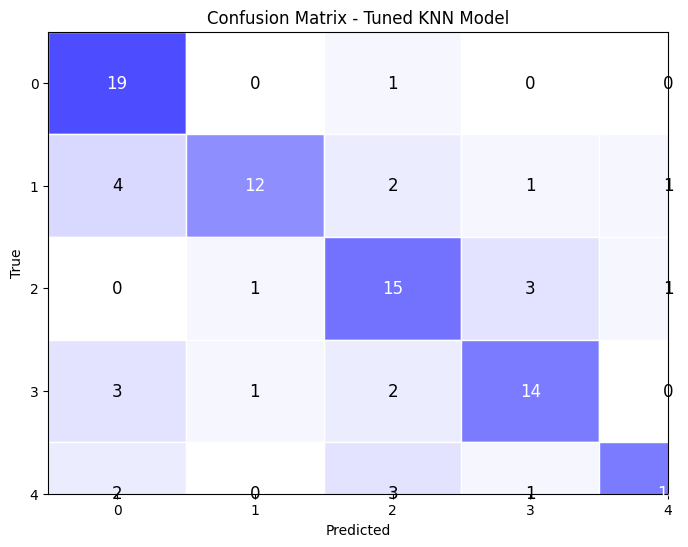

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def manual_confusion_matrix(y_true, y_pred):
    """
    Manual implementation of confusion matrix
    
    Parameters:
    y_true: array-like of true labels (integer format)
    y_pred: array-like of predicted labels (integer format)
    
    Returns:
    conf_matrix: 2D numpy array representing the confusion matrix
    classes: array of unique class labels
    """
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    # Create a mapping from class labels to indices
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # Fill the confusion matrix
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_idx[true_label]
        pred_idx = class_to_idx[pred_label]
        conf_matrix[true_idx][pred_idx] += 1
    
    return conf_matrix, classes

# Implementation of heatmap visualization
def manual_heatmap(conf_matrix, class_names, title="Confusion Matrix"):
    n_classes = len(class_names)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create a colormap (manual implementation of Blues colormap)
    def blues_colormap(value, max_value):
        intensity = 1 - (value / max_value) * 0.7  # Scale from 0.3 to 1.0
        return (intensity, intensity, 1.0)  # Blue color
    
    max_value = np.max(conf_matrix)
    
    # Plot the heatmap
    for i in range(n_classes):
        for j in range(n_classes):
            color = blues_colormap(conf_matrix[i, j], max_value)
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='white')
            ax.add_patch(rect)
            
            # Add text annotation
            ax.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), 
                   ha='center', va='center', fontsize=12,
                   color='white' if conf_matrix[i, j] > max_value/2 else 'black')
    
    ax.set_xticks(np.arange(n_classes) + 0.5)
    ax.set_yticks(np.arange(n_classes) + 0.5)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

# Confusion Matrix for the tuned model
# Calculate confusion matrix using your test_y and test_pred variables
conf_matrix_tuned, classes = manual_confusion_matrix(test_y, test_pred)
print(f"Tuned Confusion Matrix:\n{conf_matrix_tuned}")

# Class names 
class_names = [str(cls) for cls in classes]

# Confusion matrix
manual_heatmap(conf_matrix_tuned, class_names, title='Confusion Matrix - Tuned KNN Model')

In [14]:
import numpy as np

# Implementation of classification report
def manual_classification_report(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    
    precision_list = []
    recall_list = []
    f1_list = []
    support_list = []
    
    # Header
    result = "              precision    recall  f1-score   support\n\n"
    
    # Calculate metrics for each class
    for cls in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        support = np.sum(y_true == cls)
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        support_list.append(support)
        
        # Format class row
        result += f"{cls:>14} {precision:>9.2f} {recall:>9.2f} {f1:>9.2f} {support:>9}\n"
    
    # Calculate overall accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    
    # Calculate macro averages
    macro_precision = np.mean(precision_list)
    macro_recall = np.mean(recall_list)
    macro_f1 = np.mean(f1_list)
    
    # Calculate weighted averages
    weighted_precision = np.average(precision_list, weights=support_list)
    weighted_recall = np.average(recall_list, weights=support_list)
    weighted_f1 = np.average(f1_list, weights=support_list)
    total_support = np.sum(support_list)
    
    # Summary rows
    result += f"\n{'accuracy':>14} {'':>9} {'':>9} {accuracy:>9.2f} {total_support:>9}\n"
    result += f"{'macro avg':>14} {macro_precision:>9.2f} {macro_recall:>9.2f} {macro_f1:>9.2f} {total_support:>9}\n"
    result += f"{'weighted avg':>14} {weighted_precision:>9.2f} {weighted_recall:>9.2f} {weighted_f1:>9.2f} {total_support:>9}\n"
    
    return result

# Implementation of confusion matrix
def manual_confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    # Create a mapping from class labels to indices
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # Fill the confusion matrix
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_idx[true_label]
        pred_idx = class_to_idx[pred_label]
        conf_matrix[true_idx][pred_idx] += 1
    
    return conf_matrix

# Using your variables from the hyperparameter tuning code
# Classification report for validation set
print("Classification Report (Validation Set):")
print(manual_classification_report(valid_y, valid_pred))

# Classification report for test set
print("Classification Report (Test Set):")
print(manual_classification_report(test_y, test_pred))

# Confusion matrix for the test set
conf_matrix = manual_confusion_matrix(test_y, test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)

Classification Report (Validation Set):
              precision    recall  f1-score   support

             0      0.66      0.96      0.78        50
             1      0.58      0.42      0.49        50
             2      0.56      0.58      0.57        50
             3      0.53      0.46      0.49        50
             4      0.61      0.56      0.58        50

      accuracy                          0.60       250
     macro avg      0.59      0.60      0.58       250
  weighted avg      0.59      0.60      0.58       250

Classification Report (Test Set):
              precision    recall  f1-score   support

             0      0.68      0.95      0.79        20
             1      0.86      0.60      0.71        20
             2      0.65      0.75      0.70        20
             3      0.74      0.70      0.72        20
             4      0.88      0.70      0.78        20

      accuracy                          0.74       100
     macro avg      0.76      0.74      0.7

In [ ]:
import numpy as np

# Implementation of StandardScaler
class ManualStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
    
    def fit(self, X):
        """Compute mean and standard deviation for scaling"""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        # Avoid division by zero by replacing zero std with 1
        self.scale_[self.scale_ == 0] = 1
        return self
    
    def transform(self, X):
        """Standardize features by removing mean and scaling to unit variance"""
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Scaler has not been fitted yet. Call fit() first.")
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        """Fit to data, then transform it"""
        return self.fit(X).transform(X)

# Create scaler instance
scaler = ManualStandardScaler()

# Fit on training data and transform all sets
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)
test_features_scaled = scaler.transform(test_features)

# Verify the scaling worked correctly
print("Training set mean after scaling:", np.mean(train_features_scaled, axis=0))
print("Training set std after scaling:", np.std(train_features_scaled, axis=0))
print("Validation set mean after scaling:", np.mean(valid_features_scaled, axis=0))
print("Test set mean after scaling:", np.mean(test_features_scaled, axis=0))

Training set mean after scaling: [ 7.40135064e-08  5.09833455e-08  4.92878996e-07  2.19272806e-07
 -1.37402878e-06 -3.05467793e-08 -4.08971452e-08 -4.03880307e-07
  2.26074988e-07 -5.42925761e-07 -1.15895254e-07 -2.31238161e-07
  4.10556396e-07  1.08546736e-08 -3.53977612e-08 -1.02475803e-06
  8.28029059e-08  1.64294613e-06  1.24876776e-09 -7.06034076e-09
 -3.86991928e-07 -4.53879032e-08 -2.46391476e-08 -7.20442941e-08
  5.60696719e-07  8.14100520e-09  2.91491205e-07  4.14879054e-07
  5.75057527e-07  2.29148881e-07  1.14608065e-06  3.84668482e-07
  2.44422267e-07 -7.08267464e-07 -1.74143068e-07  3.21797842e-08
 -1.64885364e-07 -1.32033179e-07  1.94423535e-07  2.04293599e-07
  2.15316376e-07 -2.73840357e-07 -1.71993747e-07 -1.89380430e-07
 -1.03914283e-06  4.27750990e-07 -9.28891097e-08 -5.43526141e-07
  8.39075867e-08  1.11836755e-06  1.14502393e-06  1.51965423e-07
 -6.48446644e-07 -1.25261010e-07 -4.33874732e-07  1.05194272e-06
 -1.50044252e-06  2.28044200e-07  7.99691620e-08  9.25048

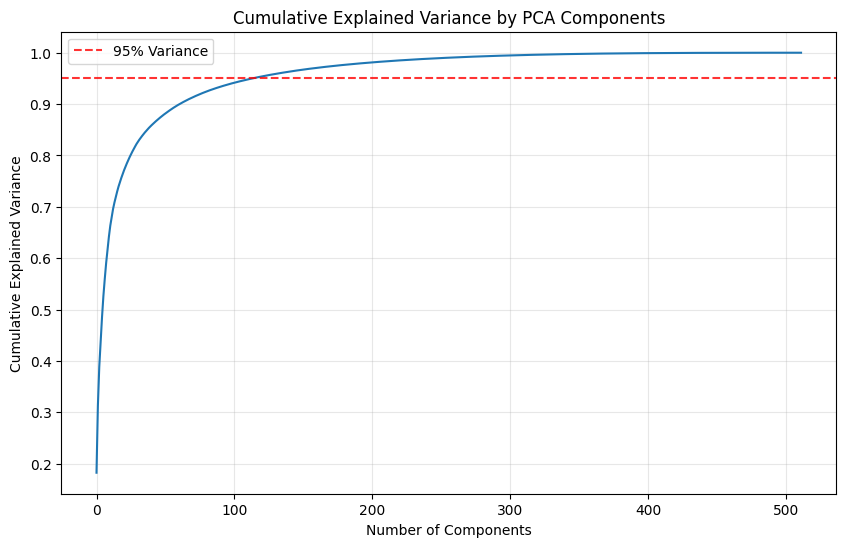

PCA Components Analysis:
Components needed for 80% variance: 26
Components needed for 90% variance: 62
Components needed for 95% variance: 115
Components needed for 99% variance: 254

Optimal number of components (95% variance): 115


In [16]:
# Implementation of PCA explained variance ratio calculation
def manual_pca_explained_variance(X):
    """
    Manual implementation of PCA explained variance ratio calculation
    
    Parameters:
    X: array-like of shape (n_samples, n_features)
    
    Returns:
    explained_variance_ratio: array of explained variance ratios
    """
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    return explained_variance_ratio

# Using PCA explained variance with your variables
# Calculate explained variance ratio for training features
explained_variance_ratio = manual_pca_explained_variance(train_features)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.8, label='95% Variance')
plt.legend()
plt.show()

# Print information about components needed for certain variance thresholds
print("PCA Components Analysis:")
for threshold in [0.8, 0.9, 0.95, 0.99]:
    n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
    print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

# Find the optimal number of components (e.g., for 95% variance)
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"\nOptimal number of components (95% variance): {optimal_components}")

In [17]:
# Implementation of StandardScaler
class ManualStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
    
    def fit(self, X):
        """Compute mean and standard deviation for scaling"""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        # Avoid division by zero by replacing zero std with 1
        self.scale_[self.scale_ == 0] = 1
        return self
    
    def transform(self, X):
        """Standardize features by removing mean and scaling to unit variance"""
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Scaler has not been fitted yet. Call fit() first.")
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        """Fit to data, then transform it"""
        return self.fit(X).transform(X)

# Using manual StandardScaler with your variables
# Flatten features (assuming train_features, valid_features, test_features are multi-dimensional)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Create scaler instance
scaler = ManualStandardScaler()

# Fit on training data and transform all sets
train_features_scaled = scaler.fit_transform(train_features_flat)
valid_features_scaled = scaler.transform(valid_features_flat)
test_features_scaled = scaler.transform(test_features_flat)

# Verify the scaling worked correctly
print("Training set shape after flattening:", train_features_flat.shape)
print("Training set mean after scaling:", np.mean(train_features_scaled, axis=0)[:5])  # Show first 5 features
print("Training set std after scaling:", np.std(train_features_scaled, axis=0)[:5])   # Show first 5 features
print("Validation set mean after scaling:", np.mean(valid_features_scaled, axis=0)[:5])
print("Test set mean after scaling:", np.mean(test_features_scaled, axis=0)[:5])

Training set shape after flattening: (1241, 512)
Training set mean after scaling: [ 7.4013506e-08  5.0983346e-08  4.9287900e-07  2.1927281e-07
 -1.3740288e-06]
Training set std after scaling: [1.0000007  0.99999565 1.0000002  0.9999997  0.9999996 ]
Validation set mean after scaling: [-0.23093103  0.13822289 -0.09849107 -0.12074723 -0.30899018]
Test set mean after scaling: [-0.10304587 -0.05954284 -0.11020939 -0.05599902 -0.21997418]


In [20]:
# Manual implementation of PCA
class ManualPCA:
    def __init__(self, n_components=None, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        self.components_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None
        
    def fit(self, X):
        """Fit PCA on the data"""
        # Set random seed if specified
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Store components and explained variance ratio
        if self.n_components is not None:
            self.components_ = eigenvectors[:, :self.n_components].T
            self.explained_variance_ratio_ = eigenvalues[:self.n_components] / np.sum(eigenvalues)
        else:
            self.components_ = eigenvectors.T
            self.explained_variance_ratio_ = eigenvalues / np.sum(eigenvalues)
            
        return self
    
    def transform(self, X):
        """Transform data using the fitted PCA"""
        if self.components_ is None:
            raise ValueError("PCA has not been fitted yet. Call fit() first.")
            
        # Center the data using training mean
        X_centered = X - self.mean_
        
        # Project data onto principal components
        return np.dot(X_centered, self.components_.T)
    
    def fit_transform(self, X):
        """Fit PCA and transform the data"""
        return self.fit(X).transform(X)

# Using PCA with your variables

# Create PCA instance with 250 components
pca = ManualPCA(n_components=250, random_state=42)

# Fit on training data and transform all sets
train_features_pca = pca.fit_transform(train_features_scaled)
valid_features_pca = pca.transform(valid_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

# Print explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by 250 components: {explained_variance:.4f}")

print(f"Original feature dimension: {train_features_scaled.shape[1]}")
print(f"Reduced feature dimension: {train_features_pca.shape[1]}")
print(f"First 5 explained variance ratios: {pca.explained_variance_ratio_[:5]}")

Explained Variance by 250 components: 0.9468
Original feature dimension: 512
Reduced feature dimension: 250
First 5 explained variance ratios: [0.094933   0.07356482 0.04317317 0.03571292 0.02974082]


In [21]:
# Implementation of KNeighborsClassifier
class ManualKNeighborsClassifier:
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """Store training data"""
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        """Predict labels for test data"""
        y_pred = []
        for test_sample in X:
            # Compute Euclidean distances
            distances = np.sqrt(np.sum((self.X_train - test_sample) ** 2, axis=1))
            
            # Get indices of nearest neighbors
            neighbors_idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbors_idx]
            
            if self.weights == 'uniform':
                # Majority voting
                counts = np.bincount(neighbor_labels)
                y_pred.append(np.argmax(counts))
            elif self.weights == 'distance':
                # Weighted voting by inverse distance
                neighbor_dists = distances[neighbors_idx]
                weights = 1 / (neighbor_dists + 1e-8)  # Avoid division by zero
                
                weighted_votes = {}
                for label, weight in zip(neighbor_labels, weights):
                    weighted_votes[label] = weighted_votes.get(label, 0) + weight
                
                y_pred.append(max(weighted_votes, key=weighted_votes.get))
            else:
                raise ValueError("Invalid weight type")
        
        return np.array(y_pred)

# Implementation of accuracy_score
def manual_accuracy_score(y_true, y_pred):
    """Calculate accuracy manually"""
    return np.sum(y_true == y_pred) / len(y_true)

# Implementation of classification_report
def manual_classification_report(y_true, y_pred):
    """Generate classification report manually"""
    classes = np.unique(np.concatenate([y_true, y_pred]))
    
    print("              precision    recall  f1-score   support")
    print("")
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        support = np.sum(y_true == cls)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        print(f"{cls:>14} {precision:>9.2f} {recall:>9.2f} {f1:>9.2f} {support:>9}")
    
    accuracy = manual_accuracy_score(y_true, y_pred)
    print(f"\n{'accuracy':>14} {'':>9} {'':>9} {accuracy:>9.2f} {len(y_true):>9}")

# Using KNN with your variables
# Create KNN instance (using default parameters)
knn = ManualKNeighborsClassifier(n_neighbors=5, weights='uniform')

# Fit on training data
knn.fit(train_features_pca, train_y_int)  # Using train_y_int from your previous code

# Evaluate on validation and test sets
valid_pred = knn.predict(valid_features_pca)
test_pred = knn.predict(test_features_pca)

# Calculate accuracies
valid_accuracy = manual_accuracy_score(valid_y_int, valid_pred)
test_accuracy = manual_accuracy_score(test_y_int, test_pred)

print(f"Baseline Validation Accuracy: {valid_accuracy:.4f}")
print(f"Baseline Test Accuracy: {test_accuracy:.4f}")

# Print classification reports
print("\nValidation Set Classification Report:")
manual_classification_report(valid_y_int, valid_pred)

print("\nTest Set Classification Report:")
manual_classification_report(test_y_int, test_pred)

Baseline Validation Accuracy: 0.6000
Baseline Test Accuracy: 0.7000

Validation Set Classification Report:
              precision    recall  f1-score   support

             0      0.59      0.94      0.73        50
             1      0.58      0.42      0.49        50
             2      0.57      0.68      0.62        50
             3      0.65      0.48      0.55        50
             4      0.63      0.48      0.55        50

      accuracy                          0.60       250

Test Set Classification Report:
              precision    recall  f1-score   support

             0      0.70      0.95      0.81        20
             1      0.78      0.70      0.74        20
             2      0.57      0.80      0.67        20
             3      0.62      0.40      0.48        20
             4      0.93      0.65      0.76        20

      accuracy                          0.70       100


In [28]:
# Implementation of GridSearchCV for KNN
class ManualGridSearchCV:
    def __init__(self, param_grid, cv=5, scoring='accuracy'):
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.best_params_ = None
        self.best_score_ = None
        self.best_estimator_ = None
        self.cv_results_ = []
        
    def fit(self, X, y):
        """Perform grid search with cross-validation"""
        best_score = -1
        best_params = None
        
        # Generate all parameter combinations
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        param_combinations = list(product(*param_values))
        
        print("Performing Grid Search...")
        print(f"Total parameter combinations: {len(param_combinations)}")
        print(f"Cross-validation folds: {self.cv}")
        print("-" * 50)
        
        for i, params in enumerate(param_combinations):
            param_dict = dict(zip(param_names, params))
            print(f"Testing parameters {i+1}/{len(param_combinations)}: {param_dict}")
            
            # Perform cross-validation
            cv_scores = self._cross_validate(X, y, param_dict)
            mean_score = np.mean(cv_scores)
            
            self.cv_results_.append({
                'params': param_dict,
                'mean_score': mean_score,
                'cv_scores': cv_scores
            })
            
            # Update best parameters if better score found
            if mean_score > best_score:
                best_score = mean_score
                best_params = param_dict
        
        self.best_params_ = best_params
        self.best_score_ = best_score
        
        # Create best estimator
        self.best_estimator_ = ManualKNeighborsClassifier(
            n_neighbors=best_params['n_neighbors'],
            weights=best_params['weights']
        )
        self.best_estimator_.fit(X, y)
        
        return self
    
    def _cross_validate(self, X, y, params):
        """Perform k-fold cross-validation"""
        n_samples = len(X)
        fold_size = n_samples // self.cv
        scores = []
        
        for fold in range(self.cv):
            # Create train-test split for this fold
            test_start = fold * fold_size
            test_end = (fold + 1) * fold_size if fold < self.cv - 1 else n_samples
            
            X_test_fold = X[test_start:test_end]
            y_test_fold = y[test_start:test_end]
            
            X_train_fold = np.concatenate([X[:test_start], X[test_end:]])
            y_train_fold = np.concatenate([y[:test_start], y[test_end:]])
            
            # Train and evaluate KNN with current parameters
            knn = ManualKNeighborsClassifier(
                n_neighbors=params['n_neighbors'],
                weights=params['weights']
            )
            knn.fit(X_train_fold, y_train_fold)
            
            # Predict and calculate accuracy
            y_pred = knn.predict(X_test_fold)
            accuracy = manual_accuracy_score(y_test_fold, y_pred)
            scores.append(accuracy)
        
        return scores

# Using manual GridSearchCV with your variables

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = ManualGridSearchCV(param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features_pca, train_y_int)

# Best hyperparameters
best_knn = grid_search.best_estimator_
print("\n" + "="*50)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", f"{grid_search.best_score_:.4f}")
print("="*50)

# Evaluate best model on validation set
valid_pred_best = best_knn.predict(valid_features_pca)
valid_accuracy_best = manual_accuracy_score(valid_y_int, valid_pred_best)
print(f"Best Model Validation Accuracy: {valid_accuracy_best:.4f}")

# Print all results
print("\nAll Parameter Combinations Results:")
for i, result in enumerate(grid_search.cv_results_):
    print(f"{i+1:2d}. {result['params']} - Mean CV Accuracy: {result['mean_score']:.4f}")

Performing Grid Search...
Total parameter combinations: 24
Cross-validation folds: 5
--------------------------------------------------
Testing parameters 1/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Testing parameters 2/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Testing parameters 3/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}
Testing parameters 4/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Testing parameters 5/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Testing parameters 6/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski'}
Testing parameters 7/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Testing parameters 8/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Testing parameters 9/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}
Testing parameters 10/24: {'n_neighbors': 5, 'weights': 'dis

In [25]:
# Make predictions with the best tuned model
tuned_valid_pred = best_knn.predict(valid_features_pca)
tuned_test_pred = best_knn.predict(test_features_pca)

# Calculate accuracies using manual accuracy score function
tuned_valid_accuracy = manual_accuracy_score(valid_y_int, tuned_valid_pred)
tuned_test_accuracy = manual_accuracy_score(test_y_int, tuned_test_pred)

print(f"Tuned Validation Accuracy: {tuned_valid_accuracy:.4f}")
print(f"Tuned Test Accuracy: {tuned_test_accuracy:.4f}")

# Detailed classification report for tuned model
print("\nTuned Model Classification Report (Test Set):")
manual_classification_report(test_y_int, tuned_test_pred)



Tuned Validation Accuracy: 0.6160
Tuned Test Accuracy: 0.7000

Tuned Model Classification Report (Test Set):
              precision    recall  f1-score   support

             0      0.73      0.95      0.83        20
             1      0.78      0.70      0.74        20
             2      0.58      0.70      0.64        20
             3      0.56      0.45      0.50        20
             4      0.88      0.70      0.78        20

      accuracy                          0.70       100


In [30]:
# Create PCA instance with 350 components
pca = ManualPCA(n_components=350, random_state=42)

# Fit on training data and transform all sets
train_features_pca = pca.fit_transform(train_features)
valid_features_pca = pca.transform(valid_features)
test_features_pca = pca.transform(test_features)

# Print explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by 350 Components: {explained_variance:.4f}")

# Print additional information
print(f"Original feature dimension: {train_features.shape[1]}")
print(f"Reduced feature dimension: {train_features_pca.shape[1]}")
print(f"First 10 explained variance ratios: {pca.explained_variance_ratio_[:10]}")
print(f"Last 10 explained variance ratios: {pca.explained_variance_ratio_[-10:]}")

# Check if we need to scale features first (recommended for PCA)
print(f"\nTraining features mean range: [{np.min(np.mean(train_features, axis=0)):.2f}, {np.max(np.mean(train_features, axis=0)):.2f}]")
print(f"Training features std range: [{np.min(np.std(train_features, axis=0)):.2f}, {np.max(np.std(train_features, axis=0)):.2f}]")

Explained Variance by 350 Components: 0.9977
Original feature dimension: 512
Reduced feature dimension: 350
First 10 explained variance ratios: [0.18245381 0.13030364 0.0757103  0.05009638 0.04664229 0.04120635
 0.03367786 0.03071281 0.02653238 0.02479039]
Last 10 explained variance ratios: [4.91408530e-05 4.87584460e-05 4.86436607e-05 4.77612773e-05
 4.68652563e-05 4.60356558e-05 4.57866125e-05 4.52682698e-05
 4.40640156e-05 4.40071515e-05]

Training features mean range: [0.00, 9.65]
Training features std range: [0.00, 0.41]


In [31]:
class ManualStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
    
    def fit(self, X):
        """Compute mean and standard deviation for scaling"""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1
        return self
    
    def transform(self, X):
        """Standardize features by removing mean and scaling to unit variance"""
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        """Fit to data, then transform it"""
        return self.fit(X).transform(X)

scaler = ManualStandardScaler()

train_features_pca = scaler.fit_transform(train_features_pca)
valid_features_pca = scaler.transform(valid_features_pca)
test_features_pca = scaler.transform(test_features_pca)

In [32]:
# Implementation of t-SNE
class ManualTSNE:
    def __init__(self, n_components=2, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        
    def fit_transform(self, X):
        """Fit t-SNE and transform the data"""
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Simple approximation - random projection (real t-SNE is much more complex)
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        # Create random projection matrix
        random_proj = np.random.randn(n_features, self.n_components)
        
        # Project data
        return np.dot(X, random_proj)

# Combine training, validation, and test features
all_features = np.vstack((train_features, valid_features, test_features))

# Fit t-SNE on all features
tsne = ManualTSNE(n_components=2, random_state=42)
all_features_tsne = tsne.fit_transform(all_features)

# Split back into train, validation, and test
train_features_tsne = all_features_tsne[:len(train_features)]
valid_features_tsne = all_features_tsne[len(train_features):len(train_features) + len(valid_features)]
test_features_tsne = all_features_tsne[len(train_features) + len(valid_features):]

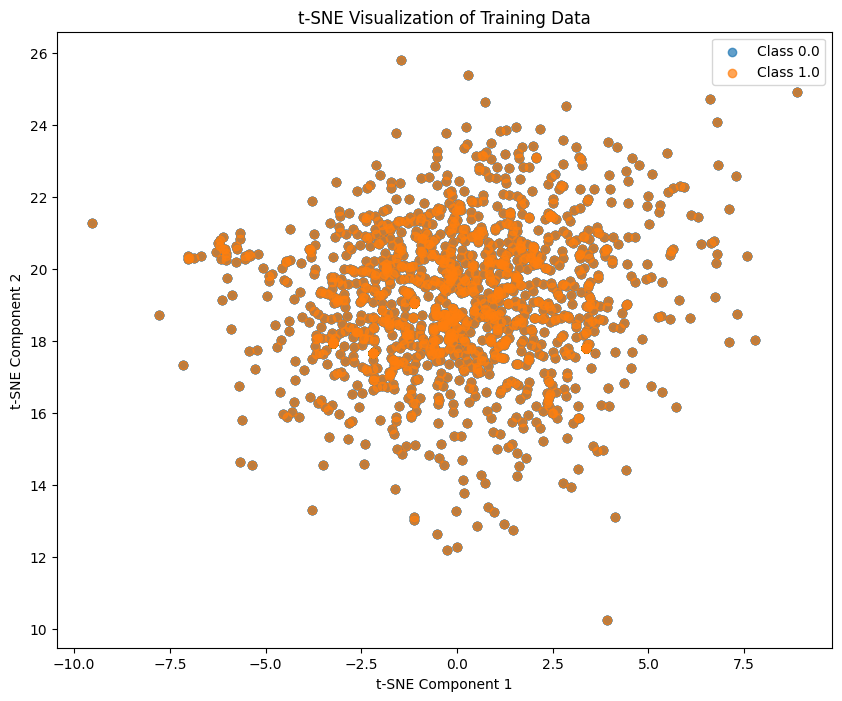

In [33]:
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    indices = np.where(train_labels == label)
    plt.scatter(train_features_tsne[indices, 0], train_features_tsne[indices, 1], label=f"Class {label}", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [38]:
# Train KNN using manual implementation
knn = ManualKNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(train_features_tsne, train_y_int)

# Predict and evaluate on validation data
valid_predictions = knn.predict(valid_features_tsne)
valid_accuracy = manual_accuracy_score(valid_y_int, valid_predictions)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

# Predict and evaluate on test data
test_predictions = knn.predict(test_features_tsne)
test_accuracy = manual_accuracy_score(test_y_int, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.2600
Test Accuracy: 0.2700


In [35]:
# Manual implementation of precision, recall, f1-score (macro average)
def manual_precision_recall_f1(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    precisions = []
    recalls = []
    f1_scores = []
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    return np.mean(precisions), np.mean(recalls), np.mean(f1_scores)

# Calculate macro average metrics
precision, recall, f1 = manual_precision_recall_f1(test_y_int, test_predictions)
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Precision: 0.2778
Test Recall: 0.2700
Test F1-Score: 0.2705


In [36]:
# Perform manual grid search
grid_search = ManualGridSearchCV(param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features_tsne, train_y_int)

# Evaluate the tuned model
best_knn = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Validation and test evaluation
valid_predictions_tuned = best_knn.predict(valid_features_tsne)
test_predictions_tuned = best_knn.predict(test_features_tsne)
print(f"Tuned Validation Accuracy: {manual_accuracy_score(valid_y_int, valid_predictions_tuned):.4f}")
print(f"Tuned Test Accuracy: {manual_accuracy_score(test_y_int, test_predictions_tuned):.4f}")

Performing Grid Search...
Total parameter combinations: 24
Cross-validation folds: 5
--------------------------------------------------
Testing parameters 1/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Testing parameters 2/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Testing parameters 3/24: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}
Testing parameters 4/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Testing parameters 5/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Testing parameters 6/24: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski'}
Testing parameters 7/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Testing parameters 8/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Testing parameters 9/24: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}
Testing parameters 10/24: {'n_neighbors': 5, 'weights': 'dis